# Image-Stitching
---
## 1) Importing the Libraries
---

In [1]:
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt

## 2) Loading the useful images
---

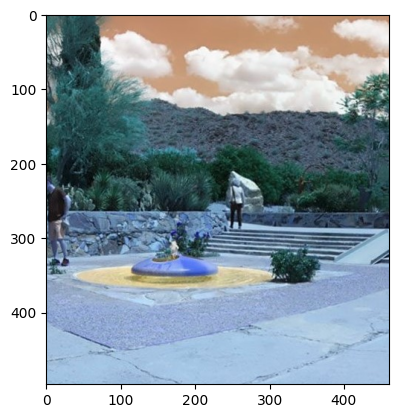

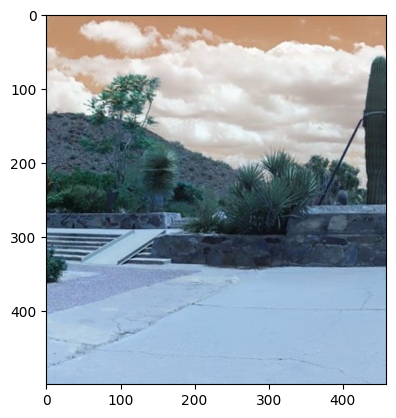

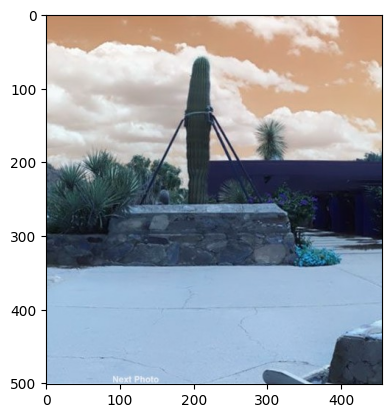

In [18]:
# Load our images
img1 = cv2.imread("./input_imgs/pic_1.jpg")
img2 = cv2.imread("./input_imgs/pic_2.jpg")
img3 = cv2.imread("./input_imgs/pic_3.jpg")

plt.imshow(img1)
plt.show()
plt.imshow(img2)
plt.show()
plt.imshow(img3)
plt.show()

## 3) Finding the key-points between two images
---
- This function helps us to get the key points between given two images.

In [3]:
def find_keypoints(img1, img2):
    orb = cv2.ORB_create(nfeatures=2000)

    # Find the key points and descriptors with ORB
    keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(img2, None)
    
    # It will find all of the matching keypoints on two images
    bf = cv2.BFMatcher_create(cv2.NORM_HAMMING)

    # Find matching points
    matches = bf.knnMatch(descriptors1, descriptors2,k=2)
    
    return [matches, keypoints1, keypoints2]

In [4]:
keypoints = find_keypoints(img1, img2)

## 3) Finding the best matches
---

In [5]:
# Finding the best matches
good = []
for m, n in keypoints[0]:
    if m.distance < 0.6 * n.distance:
        good.append(m)

## 4) Warping two images
---


In [7]:
def warpImages(img1, img2, H):
    
    rows1, cols1 = img1.shape[:2]
    rows2, cols2 = img2.shape[:2]

    list_of_points_1 = np.float32([[0,0], [0, rows1],[cols1, rows1], [cols1, 0]]).reshape(-1, 1, 2)
    temp_points = np.float32([[0,0], [0,rows2], [cols2,rows2], [cols2,0]]).reshape(-1,1,2)

    # When we have established a homography we need to warp perspective
    # Change field of view
    list_of_points_2 = cv2.perspectiveTransform(temp_points, H)

    list_of_points = np.concatenate((list_of_points_1,list_of_points_2), axis=0)
    [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)

    translation_dist = [-x_min,-y_min]

    H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])

    output_img = cv2.warpPerspective(img2, H_translation.dot(H), (x_max-x_min, y_max-y_min))
    output_img[translation_dist[1]:rows1+translation_dist[1], translation_dist[0]:cols1+translation_dist[0]] = img1

    return output_img

In [8]:
def draw_img(good, MIN_MATCH_COUNT, keypoints1, keypoints2, img1, img2):
    MIN_MATCH_COUNT = 10

    if len(good) > MIN_MATCH_COUNT:
        # Convert keypoints to an argument for findHomography
        src_pts = np.float32([ keypoints1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
        dst_pts = np.float32([ keypoints2[m.trainIdx].pt for m in good]).reshape(-1,1,2)

        # Establish a homography
        M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)

        result = warpImages(img2, img1, M)

        plt.imshow(result)
        plt.show()
        
        return result

In [9]:
import os
total_imgs = []
for i in os.listdir('./input_imgs/'):
    total_imgs.append(i)
total_imgs

['pic_1.jpg', 'pic_2.jpg', 'pic_3.jpg']

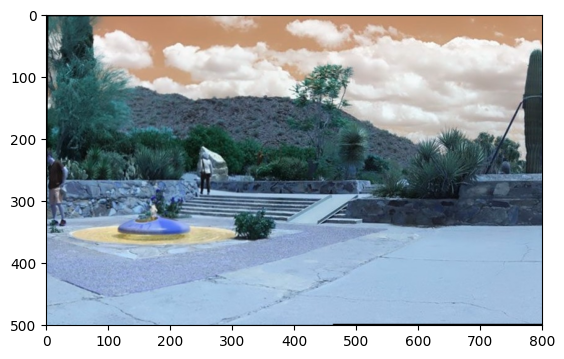

In [10]:
first_result = draw_img(good,10,keypoints[1], keypoints[2], img1, img2)

In [11]:
new_key = find_keypoints(first_result,img3)

In [12]:
final_good = []
for m, n in new_key[0]:
    if m.distance < 0.6 * n.distance:
        final_good.append(m)

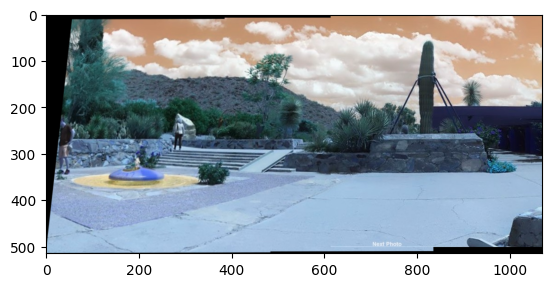

In [13]:
final_output = draw_img(final_good, 10,new_key[1], new_key[2], first_result, img3)

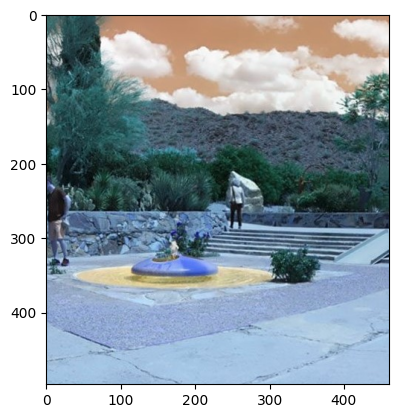

In [14]:
plt.imshow(img1)

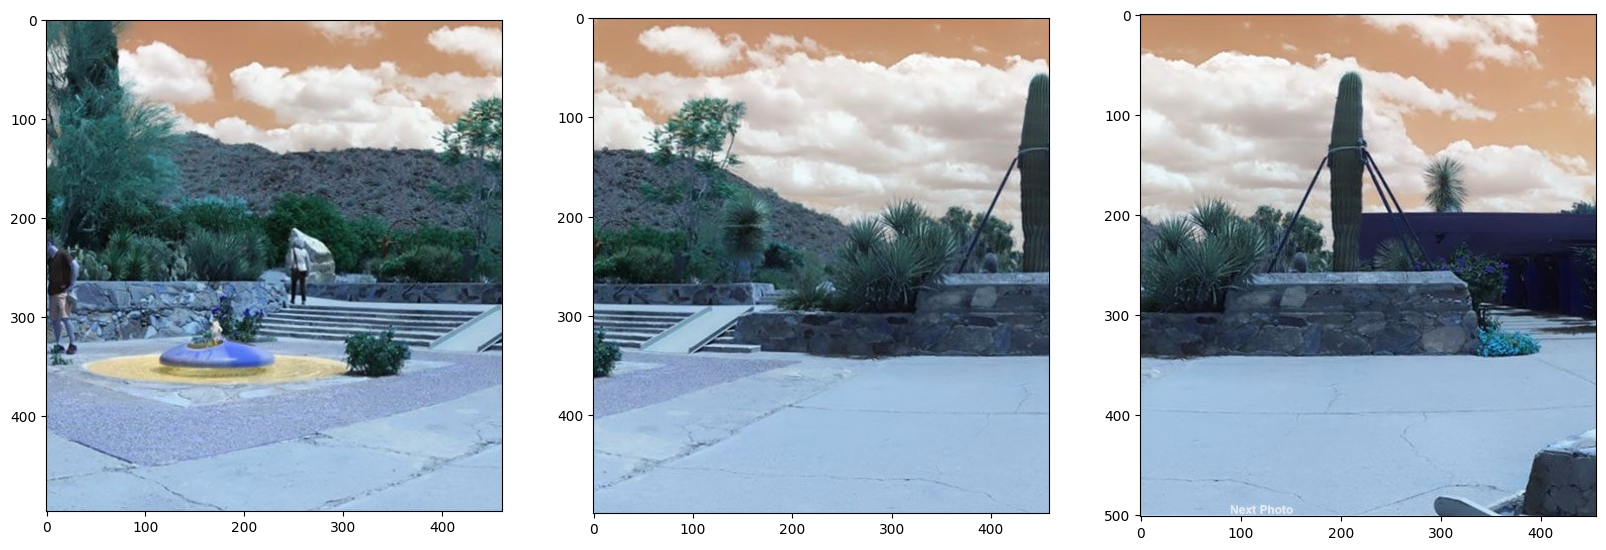

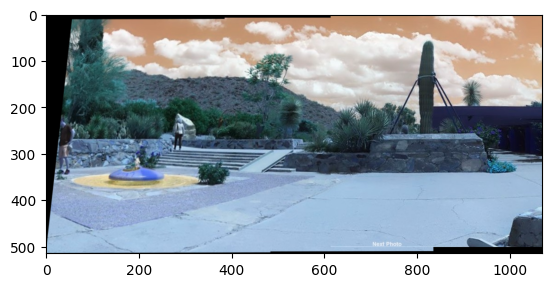

In [15]:
fig,ax = plt.subplots(1,3,figsize = (20,20))
ax[0].imshow(img1)
# plt.show()
ax[1].imshow(img2)
ax[2].imshow(img3)
plt.show()
plt.imshow(final_output)
plt.show()